<a href="https://colab.research.google.com/github/nataliasc/dyadicdecisionmaking/blob/2ifc-random-dots/dataanalysis/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Run the following in the order stated below before this script**


1.   post_experiment for every experiment_pair. Ideally this was done already after every experiment for first level checks.
2.   fit_hddm (to have the parameter estimate of each subject for various conditions)



# Set up

In [1]:
!pip install scipy==1.7.1

     |████████████████████████████████| 28.5 MB 1.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install bambi

     |████████████████████████████████| 67 kB 2.7 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 


In [3]:
import arviz as az
import bambi
import glob
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy
import seaborn as sns
from scipy.special import erfcinv
import statsmodels
sns.set_palette("Set2", desat=0.5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Part A: Is there a choice history bias in dyadic trials?


Objectives: Test the hypothesis of choice history bias from dyadic interaction and characterise the nature of the bias.

Assumes: Choice history bias after own trials

Answers the questions:
1.   Is there a history bias if the previous trial is done by the partner?



    
    



In [4]:
#calculates dprime given dataframe of a subject's response
#filter for na when calculating p(repeat)

def dprime(df):
    """
    left (-1): signal present
    right (1) : signal absent
    """
    d = 0
    c = 0
    
    #calculate hit rate,HR and false alarm rate, FA
    signal = df[df['direction'] == -1].shape[0]
    nosignal = df[df['direction'] == 1].shape[0]

    hits = df[(df['direction'] == -1) & (df['response'] == -1)].shape[0]
    falsealarms = df[(df['direction'] == 1) & (df['response'] == -1)].shape[0]
    #print(signal,hits, nosignal,falsealarms)
    try:
        hit_rate = hits/signal
        fa_rate = falsealarms/nosignal

        if not (0 <= hit_rate <= 1 and 0 <= fa_rate <= 1):
            print("Hit Rate and/or False Alarm Rate out of range")

        if hit_rate > 0:
            hit_rate = min(hit_rate, 1 - 0.5/signal)
        else:
            hit_rate = 0.5/signal

        if fa_rate < 1:
            fa_rate = max(fa_rate, 0.5/nosignal)
        else:
            fa_rate = 1 - 0.5/nosignal

        zHit = -sqrt(2) * erfcinv(2 * hit_rate)
        zFA = -sqrt(2) * erfcinv(2 * fa_rate)

        d = zHit - zFA
        c = - 0.5 * (zHit + zFA)
    except Exception as e:
        print("Couldnt determine dprime and criterion. {}".format(e))
        
     
    return d,c

In [5]:
"""
Prepare for running
Combine data of all pairs if not done already
NOTE: If the combined file doesnt already exist it indicates that fit_HDDM wasnt done. Do that first. 
"""
datasrc = "drive/MyDrive/DDM_SP_2021-22/data/coded"
datafile = "all_trials_data.csv"

#if the concatenated data from each experimnetal run exists, use that, else create the concatenated data first
data_loc = os.path.join(datasrc,datafile)
if os.path.exists(data_loc):
    trials_df = pd.read_csv(data_loc)
    print("Concatenated datafile with full experiment data found and loaded")
else:
    files = glob.glob(os.path.join(datasrc,'pair*.csv'))
    mydata = pd.concat([pd.read_csv(f) for f in files ])
    mydata.to_csv(data_loc,index=False,header=True)
    print("Concatenated datafile with full experiment data at --> {}".format(data_loc))
    trials_df = pd.read_csv(data_loc)
    

prev_trials_window = 1 #shouldnt be more the parameter value in the post_experiment script

Concatenated datafile with full experiment data found and loaded


In [6]:
subjects = trials_df['subj_idx'].unique()
print(subjects)

['280933_1' '280933_2' '659640_1' '659640_2' '725232_1' '725232_2'
 '754128_1' '754128_2' '812810_1' '812810_2' '897304_2' '897304_1'
 '900778_1' '900778_2' '958733_2' '958733_1' '268006_2' '268006_1'
 '476030_1' '476030_2']


In [7]:
individual_data = []
for sid in subjects:
    tmpdict = {}
    tmpdict['subj_idx'] = sid
    tmpdf = trials_df[trials_df['subj_idx'] == sid]
    tmpdict['dprime'], tmpdict['criterion'] = dprime(tmpdf[['direction','response']])
    tmpdict['accuracy'] = tmpdf['correct'].mean()
    tmpdict['rt'] = tmpdf['rt'].median()
    tmpdict['bias'] = tmpdf['response'].mean()
    for n in range(1,prev_trials_window + 1):
        prefix = 'l' + str(n) + '_' #prefix for the column name
        col_stim = prefix + 'stim'
        tmpdf[prefix + 'correct'] = (tmpdf[prefix + 'stim'] == tmpdf[prefix + 'resp']) * 1
        tmpdict[prefix + 'correct'] = tmpdf[prefix + 'correct'].mean()
        t = tmpdf[~tmpdf[col_stim].isna()] #filter out rows where stim is NaN
        tmpdict[prefix + 'pr'] = t[prefix + 'repeat'].mean()
        own = t[prefix + 'subject'] == sid
        tmpdict[prefix + 'pr_own'] = t.loc[own,prefix + 'repeat'].mean()
        tmpdict[prefix + 'pr_dyad'] = t.loc[~own,prefix + 'repeat'].mean()
        
        fastRTs = t['rt'] < tmpdict['rt']
        slowRTs = t['rt'] > tmpdict['rt']
        
        tmpdict[prefix + 'pr_fastRT']= np.NaN
        tmpdict[prefix + 'pr_fastRT_own']= np.NaN
        tmpdict[prefix + 'pr_fastRT_dyad']= np.NaN
        tmpdict[prefix + 'pr_slowRT']= np.NaN
        tmpdict[prefix + 'pr_slowRT_own']= np.NaN
        tmpdict[prefix + 'pr_slowRT_dyad']= np.NaN
        
        if not fastRTs.empty:
            tmpdict[prefix + 'pr_fastRT']= t.loc[fastRTs,prefix + 'repeat'].mean()
            m1 = (t[prefix + 'subject'] == sid) & (t['rt'] < tmpdict['rt'])
            m2 = (t[prefix + 'subject'] != sid) & (t['rt'] < tmpdict['rt'])
            if not m1.empty:
                tmpdict[prefix + 'pr_fastRT_own']= t.loc[m1,prefix + 'repeat'].mean()
            if not m2.empty:
                tmpdict[prefix + 'pr_fastRT_dyad']= t.loc[m2,prefix + 'repeat'].mean()
        
        if not slowRTs.empty:
            tmpdict[prefix + 'pr_slowRT']= t.loc[slowRTs,prefix + 'repeat'].mean()
            m1 = (t[prefix + 'subject'] == sid) & (t['rt'] > tmpdict['rt'])
            m2 = (t[prefix + 'subject'] != sid) & (t['rt'] > tmpdict['rt'])
        if not m1.empty:
            tmpdict[prefix + 'pr_slowRT_own']= t.loc[m1,prefix + 'repeat'].mean()
        if not m2.empty:
            tmpdict[prefix + 'pr_slowRT_dyad']= t.loc[m2,prefix + 'repeat'].mean()
        
        
    individual_data.append(tmpdict)

individual_df = pd.DataFrame(individual_data)
display(individual_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,subj_idx,dprime,criterion,accuracy,rt,bias,l1_correct,l1_pr,l1_pr_own,l1_pr_dyad,l1_pr_fastRT,l1_pr_fastRT_own,l1_pr_fastRT_dyad,l1_pr_slowRT,l1_pr_slowRT_own,l1_pr_slowRT_dyad
0,280933_1,1.153914,0.146230,0.713402,1.078531,0.076289,0.779381,0.459459,0.456067,0.462810,0.413223,0.396947,0.432432,0.504202,0.523364,0.488550
1,280933_2,2.396819,-0.488261,0.852362,0.913726,-0.153543,0.775591,0.508911,0.469697,0.551867,0.498024,0.476562,0.520000,0.519841,0.463235,0.586207
2,659640_1,2.270160,-0.048344,0.871456,0.811110,-0.013233,0.824197,0.455238,0.446043,0.465587,0.452471,0.500000,0.404580,0.459770,0.400000,0.534483
3,659640_2,1.174778,-0.041515,0.721627,0.726120,-0.036403,0.751606,0.555315,0.625571,0.491736,0.549356,0.623853,0.483871,0.559471,0.623853,0.500000
4,725232_1,4.099362,-0.551058,0.964623,0.644632,-0.075472,0.731132,0.528436,0.520000,0.538071,0.509434,0.523810,0.488372,0.547619,0.515152,0.576577
5,725232_2,0.019072,0.077703,0.504043,0.679856,0.061995,0.760108,0.384824,0.344828,0.420513,0.362162,0.305556,0.398230,0.409836,0.376238,0.451220
6,754128_1,3.103126,0.202819,0.936000,0.438246,0.056000,0.784000,0.465726,0.465306,0.466135,0.440000,0.406250,0.475410,0.491870,0.529915,0.457364
7,754128_2,1.196207,-0.372022,0.711968,0.488841,-0.245436,0.847870,0.489754,0.563559,0.420635,0.522449,0.666667,0.384000,0.454545,0.456897,0.452381
8,812810_1,1.888245,0.023299,0.827083,0.674502,-0.020833,0.822917,0.382664,0.391304,0.374486,0.292887,0.318519,0.259615,0.474359,0.494737,0.460432
9,812810_2,2.140807,-0.115217,0.854932,0.714718,-0.017408,0.837524,0.403883,0.365672,0.445344,0.333333,0.355705,0.302752,0.472656,0.378151,0.554745


Mean(Accuracy): 77.54%
Sem(Accuracy) : 2.73%



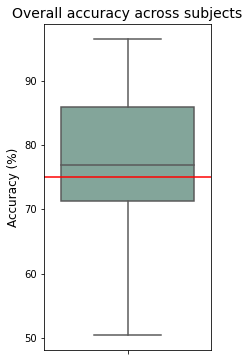

In [8]:
"""
Check the accuracy the set of subjects
"""
print("Mean(Accuracy): {:5.2%}".format(individual_df['accuracy'].mean()))
print("Sem(Accuracy) : {:5.2%}\n".format(scipy.stats.sem(individual_df['accuracy'])))
fig, ax = plt.subplots(figsize=(3,6))
sns.boxplot(y=individual_df['accuracy']*100,ax=ax)
ax.axhline(75,color='r')
ax.set_title("Overall accuracy across subjects",fontsize=14)
ax.set_ylabel("Accuracy (%)",fontsize=12)
plt.show()


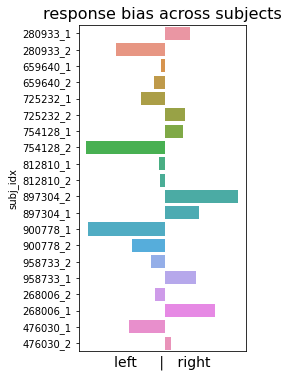

In [9]:
#Is there a response bias?
# To test: Is response bias and acccuracy correlated?
fig, ax = plt.subplots(figsize=(3,6))
sns.barplot(data=individual_df,x='bias',y='subj_idx',ax=ax)
ax.set_xticks([])
ax.set_xlabel("left     |   right",fontsize=14)
ax.set_title("response bias across subjects",fontsize=16)
plt.show()


In [10]:
"""
Plots barplot and boxplot of features in adjacent columns
plot_types: The features on which plots are to be made n=len(plot_types)
plot_df: dataframe sorted by a key feature 
"""
def do_nx2_plots(plot_types,labels,suptitle,plot_df):
    fig, ax = plt.subplots(len(plot_types),2,figsize=(10,6),facecolor='floralwhite')
    for idx,p in enumerate(plot_types):
        sns.barplot(data=plot_df,x=p,y='subj_idx',ax=ax[idx][0])
        ax[idx][0].axvline(plot_df[p].mean(), color='red',linestyle='--')
        sns.boxplot(data=plot_df,x=p,ax=ax[idx][1])
        for i in range(2):
            ax[idx][i].set_xlim(0,1)
            ax[idx][i].axvline(0.5,color='black')
            ax[idx][i].set_xlabel(labels[p],fontsize=14)

    plt.suptitle(suptitle,y=1.01,fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return  

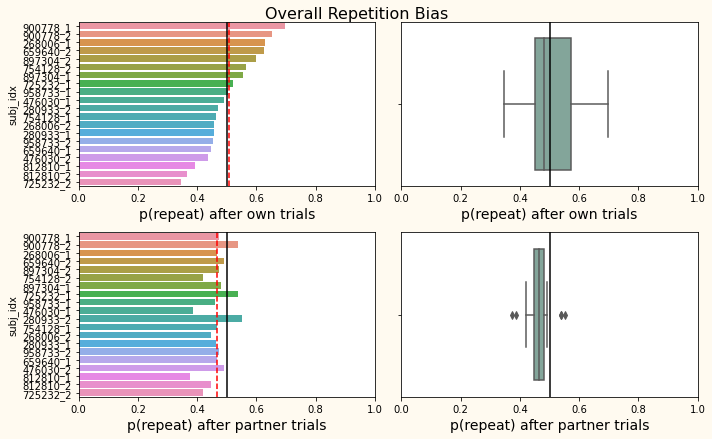

In [11]:
#repetition bias for all subjects
plots = ['l1_pr_own','l1_pr_dyad']
plot_labels = {
    'l1_pr': "p(repeat) overall",
    'l1_pr_own': "p(repeat) after own trials",
    'l1_pr_dyad': "p(repeat) after partner trials"
    
}

tmpdf = individual_df.sort_values(by=plots[0], ascending=False)

do_nx2_plots(plots,plot_labels,"Overall Repetition Bias",tmpdf)

In [12]:
def det_behavior(x):
  if x[0] >= 0.5:
    if x[1] >= 0.5:
      return 'Stay'
    else:
      return ('Win Switch')
  else:
    if x[1] >= 0.5:
      return 'Win Stay'
    else:
      return 'Switch'

In [13]:
tmpdf = trials_df[['subj_idx','l1_subject','l1_stim', 'l1_resp','l1_repeat']]
tmpdf['l1_correct'] = (tmpdf['l1_stim'] == tmpdf['l1_resp']) * 1
tmpdf['l1_subject'] = np.select([(tmpdf['subj_idx'] == tmpdf['l1_subject']),(tmpdf['subj_idx'] != tmpdf['l1_subject'])],['own','partner'])
tmpdf = tmpdf.groupby(['subj_idx','l1_subject','l1_correct'])['l1_repeat'].mean().unstack()
tmpdf['behav'] = tmpdf.apply(lambda x: det_behavior(x),axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


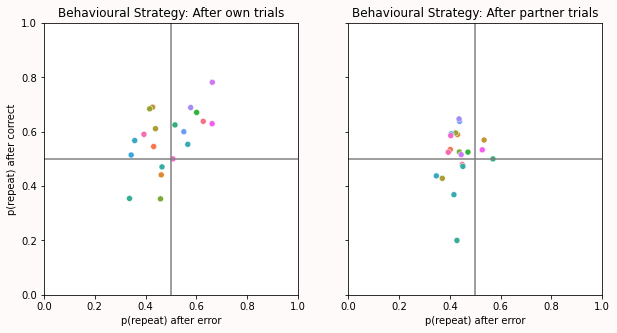

In [14]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True,facecolor='snow')
for i,val in enumerate(['own','partner']):
  d = tmpdf.xs(val, level='l1_subject')
  sns.scatterplot(x=d[1],y=d[0],hue=d.index,legend=False,ax=ax[i])
  ax[i].set_title('Behavioural Strategy: After {} trials'.format(val))
  ax[i].axvline(0.5,color='gray')
  ax[i].axhline(0.5,color='gray')
  ax[i].set_xlim(0,1)
  ax[i].set_xlabel("p(repeat) after error")
  ax[i].set_ylim(0,1)
  ax[i].set_ylabel("p(repeat) after correct")

plt.show()

**H0: There is no repetition bias after dyadic trials i.e. the p(repeat) after dyadic is 0.5**

In [ ]:
pr_diff_frm_5 = individual_df['l1_pr_dyad'] - 0.5
pr_diff_frm_5.mean()

-0.03372266765417906

In [ ]:
i=0
d = []
while i < 5000:
    df = pr_diff_frm_5.sample(n=pr_diff_frm_5.shape[0],replace=True)
    d.append(df.mean())      
    i += 1

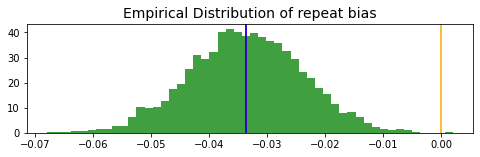

In [ ]:
fig, ax = plt.subplots(figsize=(8,2))
n, bins, patches = plt.hist(d, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(d),color='red')
plt.axvline(pr_diff_frm_5.mean(),color='blue')
plt.axvline(0,color='orange')
plt.title("Empirical Distribution of repeat bias",fontsize=14)
plt.show()

In [ ]:
ci = scipy.stats.bootstrap((pr_diff_frm_5.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.05321049788431573, high=-0.015164396244115738)


Conlusion: Post dyadic trials there is a bias. The bias is towards alternation.

**H0: There is no difference in the p(repeat) after own trial and after partner trial**

In [ ]:
pr_diff = individual_df['l1_pr_own'] - individual_df['l1_pr_dyad']

In [ ]:
pr_diff.mean()

0.03989904183818159

In [ ]:
i=0
d1 = []
while i < 5000:
    df = pr_diff.sample(n=pr_diff.shape[0],replace=True)
    d1.append(df.mean())      
    i += 1

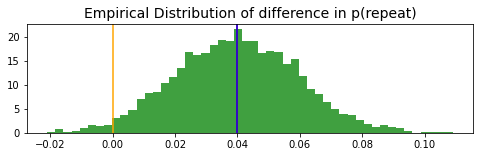

In [ ]:
fig, ax = plt.subplots(figsize=(8,2))
n, bins, patches = plt.hist(d1, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(d1),color='red')
plt.axvline(pr_diff.mean(),color='blue')
plt.axvline(0,color='orange')
plt.title("Empirical Distribution of difference in p(repeat)",fontsize=14)
plt.show()

In [ ]:
ci = scipy.stats.bootstrap((pr_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.004286448193449345, high=0.08031811559425808)


Conclusion: Choice bias after own and after partner trials are different. P(repeat) after own trial is higher, this dovetails with the previous finding that post dyadic trials there is an alternation bias.

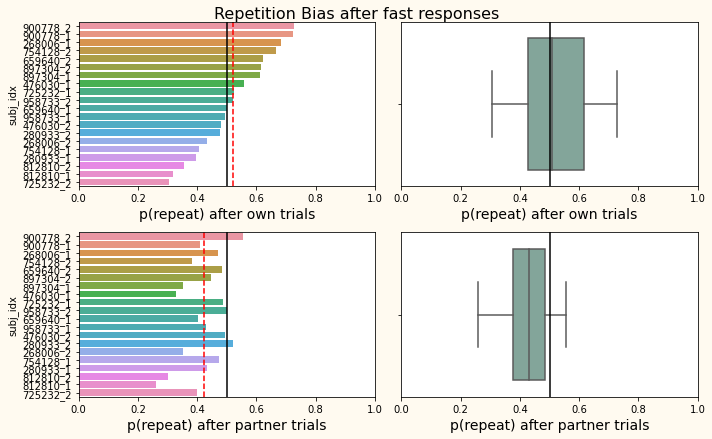

In [ ]:
#repetition bias for fast resposnes for all subjects
plots = ['l1_pr_fastRT_own','l1_pr_fastRT_dyad']
plot_labels = {
    'l1_pr_fastRT': "p(repeat) overall",
    'l1_pr_fastRT_own': "p(repeat) after own trials",
    'l1_pr_fastRT_dyad': "p(repeat) after partner trials"
    
}

tmpdf = individual_df.sort_values(by=plots[0], ascending=False)

do_nx2_plots(plots,plot_labels,"Repetition Bias after fast responses",tmpdf)

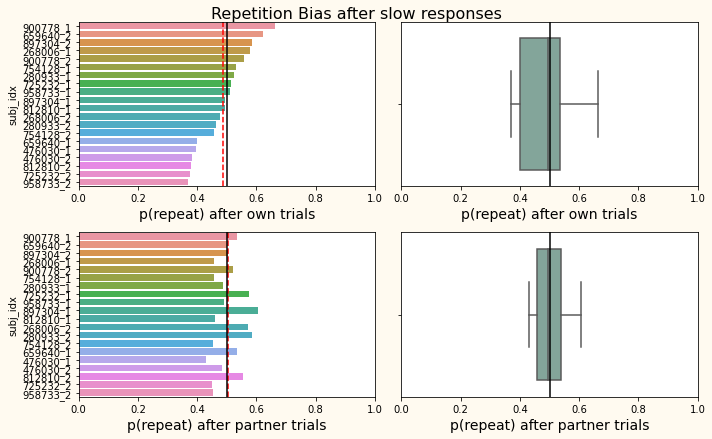

In [ ]:
#repetition bias for slow resposnes for all subjects
plots = ['l1_pr_slowRT_own','l1_pr_slowRT_dyad']
plot_labels = {
    'l1_pr_slowRT': "p(repeat) overall",
    'l1_pr_slowRT_own': "p(repeat) after own trials",
    'l1_pr_slowRT_dyad': "p(repeat) after partner trials"
    
}

tmpdf = individual_df.sort_values(by=plots[0], ascending=False)

do_nx2_plots(plots,plot_labels,"Repetition Bias after slow responses",tmpdf)

**H0: There is no difference in the p(repeat) after own trial between fast and slow responses**

In [ ]:
fastslow_diff = individual_df['l1_pr_slowRT_own'] - individual_df['l1_pr_fastRT_own']
print(fastslow_diff.mean())

-0.03245029017537311


In [ ]:
ci = scipy.stats.bootstrap((fastslow_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.07687380181582339, high=0.015896135332874636)


Null hypothesis retained.

**H0: There is no difference in the p(repeat) after partner's trial between fast and slow responses**

In [ ]:
dyadicfastslow_diff = individual_df['l1_pr_slowRT_dyad'] - individual_df['l1_pr_fastRT_dyad']
print(dyadicfastslow_diff.mean())

0.08126811023872924


In [ ]:
ci = scipy.stats.bootstrap((dyadicfastslow_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=0.04525230349463168, high=0.12409924020497574)


**H0: There is no difference in the p(repeat) after slow responses between dyadic and non-dyadic condition**

In [ ]:
slow_diff = individual_df['l1_pr_slowRT_dyad'] - individual_df['l1_pr_slowRT_own']
slow_diff.mean()

0.016700345583040642

In [ ]:
ci = scipy.stats.bootstrap((slow_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.0246422340719205, high=0.05651796675939455)


**H0: There is no difference in the p(repeat) after fast responses between dyadic and non-dyadic condition**

In [ ]:
fast_diff = individual_df['l1_pr_fastRT_dyad'] - individual_df['l1_pr_fastRT_own']
fast_diff.mean()

-0.09701805483106168

In [ ]:
ci = scipy.stats.bootstrap((fast_diff.to_numpy(),), np.mean, confidence_level=0.95)
print(ci.confidence_interval)

ConfidenceInterval(low=-0.1502004931690773, high=-0.04582218270221243)


**Analysis based on correctness of previous trial**

In [34]:
trials_df['prev_corr'] = 'Yes'
trials_df.loc[(trials_df['l1_stim'] != trials_df['l1_resp']),'prev_corr'] = 'No'

In [35]:
d = trials_df.groupby(['subj_idx','l1_subject','prev_corr'])['l1_repeat'].mean().reset_index()

In [37]:
d['l1_subject'] = np.select([(d['l1_subject'] == d['subj_idx']),(d['l1_subject'] != d['subj_idx'])],['own','partner'])

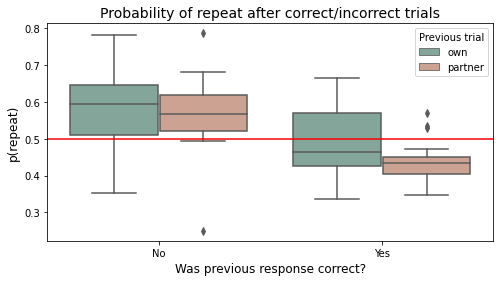

In [52]:
fig,ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=d,y='l1_repeat',x='prev_corr',hue='l1_subject',ax=ax)
ax.axhline(0.5,color='r')
ax.set_title("Probability of repeat after correct/incorrect trials",fontsize=14)
ax.set_ylabel('p(repeat)',fontsize=12)
ax.set_xlabel('Was previous response correct?',fontsize=12)
ax.legend(title='Previous trial')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


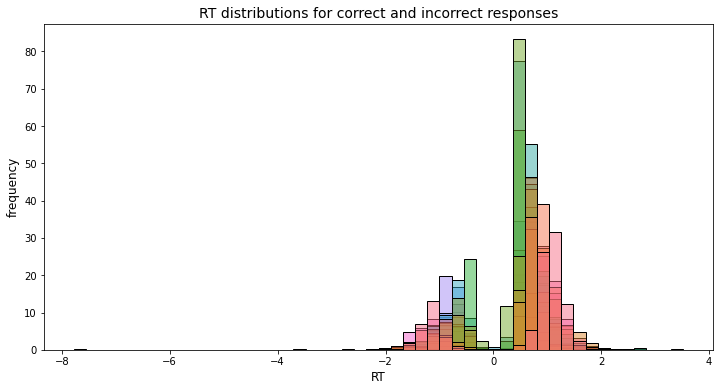

In [67]:
fig,ax = plt.subplots(figsize=(12,6))
d = trials_df[['subj_idx','rt','correct']]
d.loc[d['correct']==0,'rt'] = d['rt'] * -1

sns.histplot(data=d,x='rt',hue='subj_idx',stat='frequency',bins=50,ax=ax,legend=False)
ax.set_xlabel('RT',fontsize=12)
ax.set_ylabel('frequency',fontsize=12)
ax.set_title('RT distributions for correct and incorrect responses',fontsize=14)
plt.show()


# GLM for Validation of Choice behaviour

In [ ]:
def robust_z_score(df):
  median = df.median()
  df = df - median
  mad = 1.4296 * df.abs().median()
  df = df/mad
  return df

def fast_slow_coding(df):
  median = df.median()
  m1 = df > median
  m2 = df < median
  m3 = df == median
  df[m1] = -1
  df[m2] = 1
  df[m3] = 0

  return df

def fast_slow_coding_cat(df):
  median = df.median()
  m1 = df > median
  m2 = df < median
  m3 = df == median
  df[m1] = 'slow'
  df[m2] = 'fast'
  df[m3] = 'none'

  return df

In [ ]:
trials_df.columns

Index(['block', 'trial', 'direction', 'response', 'rt', 'subj_idx', 'correct',
       'l1_stim', 'l1_resp', 'l1_subject', 'l1_repeat', 'l2_stim', 'l2_resp',
       'l2_subject', 'l2_repeat', 'l3_stim', 'l3_resp', 'l3_subject',
       'l3_repeat', 'l4_stim', 'l4_resp', 'l4_subject', 'l4_repeat', 'l5_stim',
       'l5_resp', 'l5_subject', 'l5_repeat', 'l6_stim', 'l6_resp',
       'l6_subject', 'l6_repeat', 'l7_stim', 'l7_resp', 'l7_subject',
       'l7_repeat', 'l8_stim', 'l8_resp', 'l8_subject', 'l8_repeat', 'l9_stim',
       'l9_resp', 'l9_subject', 'l9_repeat', 'l10_stim', 'l10_resp',
       'l10_subject', 'l10_repeat', 'run_id'],
      dtype='object')

In [ ]:
model_data = trials_df[['subj_idx','direction', 'response','rt','l1_stim','l1_resp', 'l1_subject']]
model_data['l1_rt'] = model_data['rt'].shift(1) 
model_data.loc[model_data['response']==-1,'response'] = 'left'
model_data.loc[model_data['response']==1,'response'] = 'right'
model_data['l1_subject'] = np.select([(model_data['l1_subject'] == model_data['subj_idx']),(model_data['l1_subject'] != model_data['subj_idx'])],[1,-1])
model_data['l1_correct'] = np.select([(model_data['l1_stim'] == model_data['l1_resp']),(model_data['l1_stim'] != model_data['l1_resp'])],[1,-1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [ ]:
model_data.loc[:,'rt_type'] = model_data.loc[:,'l1_rt']
model_data.loc[:,'rt_cat'] = model_data.loc[:,'l1_rt']
for s in subjects:
  tmpdf = model_data.loc[model_data['subj_idx']==s,'l1_rt']
  model_data.loc[model_data['subj_idx']==s,'l1_rt'] = robust_z_score(tmpdf)
  tmpdf = model_data.loc[model_data['subj_idx']==s,'rt_type']
  model_data.loc[model_data['subj_idx']==s,'rt_type'] = fast_slow_coding(tmpdf)
  tmpdf = model_data.loc[model_data['subj_idx']==s,'rt_cat']
  model_data.loc[model_data['subj_idx']==s,'rt_cat'] = fast_slow_coding_cat(tmpdf)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
model_data

,subj_idx,direction,response,rt,l1_stim,l1_resp,l1_subject,l1_rt,l1_correct,rt_type,rt_cat
0,280933_1,1,right,1.276171,NaN,NaN,-1,NaN,-1,NaN,NaN
1,280933_2,1,left,1.399132,1.0,1.0,-1,1.130337,1,-1.0,slow
2,280933_2,1,left,1.317045,1.0,-1.0,1,1.660548,-1,-1.0,slow
3,280933_2,-1,right,1.390721,1.0,-1.0,1,1.306586,-1,-1.0,slow
4,280933_1,-1,left,1.169879,-1.0,1.0,-1,1.577256,-1,-1.0,slow
...,...,...,...,...,...,...,...,...,...,...,...
9544,476030_1,-1,left,0.711276,1.0,-1.0,-1,1.313486,-1,-1.0,slow
9545,476030_2,1,right,0.943320,-1.0,-1.0,-1,-0.558759,1,1.0,fast
9546,476030_1,-1,right,1.134057,1.0,1.0,-1,0.127164,1,-1.0,slow
9547,476030_2,-1,left,0.847869,-1.0,1.0,-1,0.810600,-1,-1.0,slow


In [ ]:
model_data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**First model:**

regressors are:


1.   Current trial: stimulus
2.   Prev trial: stimulus, response,rt,subject and their interactions





In [ ]:
model1 = bambi.Model("response['right'] ~ direction + l1_rt + l1_stim + l1_resp + l1_subject + l1_resp:l1_rt + l1_resp:l1_subject + l1_stim:l1_rt + l1_stim:l1_subject + l1_subject:l1_rt", model_data, family='bernoulli')

In [ ]:
model1

Formula: response['right'] ~ direction + l1_rt + l1_stim + l1_resp + l1_subject + l1_resp:l1_rt + l1_resp:l1_subject + l1_stim:l1_rt + l1_stim:l1_subject + l1_subject:l1_rt
Family name: Bernoulli
Link: logit
Observations: 9464
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 2.5555)
    direction ~ Normal(mu: 0.0, sigma: 2.5)
    l1_rt ~ Normal(mu: 0.0, sigma: 1.8707)
    l1_stim ~ Normal(mu: 0.0, sigma: 2.5)
    l1_resp ~ Normal(mu: 0.0, sigma: 2.5005)
    l1_subject ~ Normal(mu: 0.0, sigma: 2.5)
    l1_resp:l1_rt ~ Normal(mu: 0.0, sigma: 1.8395)
    l1_resp:l1_subject ~ Normal(mu: 0.0, sigma: 2.5001)
    l1_stim:l1_rt ~ Normal(mu: 0.0, sigma: 1.8393)
    l1_stim:l1_subject ~ Normal(mu: 0.0, sigma: 2.5003)
    l1_subject:l1_rt ~ Normal(mu: 0.0, sigma: 1.8365)


In [ ]:
result1 = model1.fit(draws=5000,chains=2)

Modeling the probability that response==right
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, l1_subject:l1_rt, l1_stim:l1_subject, l1_stim:l1_rt, l1_resp:l1_subject, l1_resp:l1_rt, l1_subject, l1_resp, l1_stim, l1_rt, direction]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 290 seconds.


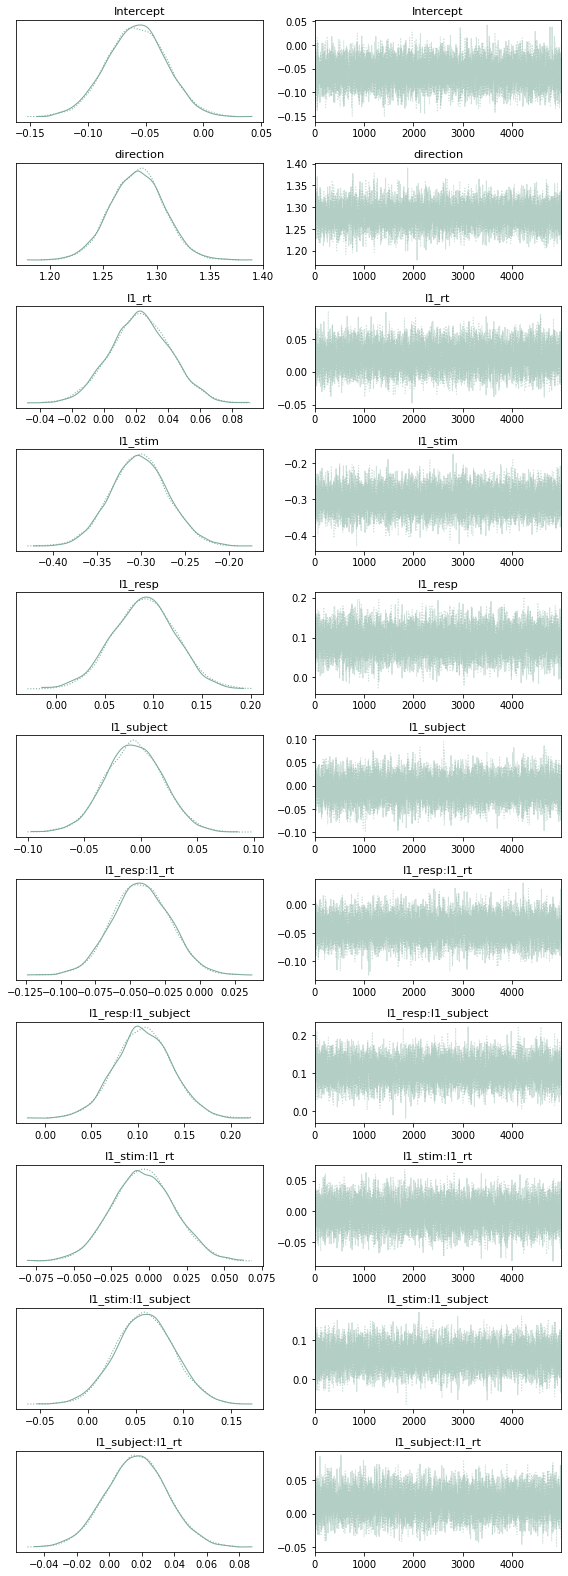

In [ ]:
fig,axes = plt.subplots(11,2,figsize=(8,22))
az.plot_trace(result1,compact=True,axes=axes)
plt.tight_layout()
plt.show()

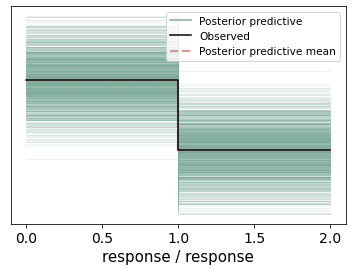

In [ ]:
post_pred1 = model1.predict(result1, kind="pps", draws=500)
az.plot_ppc(result1)

In [ ]:
az.summary(result1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.058,0.026,-0.107,-0.011,0.0,0.0,13738.0,7728.0,1.0
direction,1.282,0.025,1.234,1.327,0.0,0.0,12078.0,7308.0,1.0
l1_rt,0.023,0.019,-0.011,0.060,0.0,0.0,12583.0,7391.0,1.0
l1_stim,-0.302,0.032,-0.363,-0.242,0.0,0.0,10897.0,8208.0,1.0
l1_resp,0.091,0.032,0.029,0.149,0.0,0.0,11130.0,8195.0,1.0
l1_subject,-0.006,0.025,-0.053,0.041,0.0,0.0,12984.0,8206.0,1.0
l1_resp:l1_rt,-0.042,0.021,-0.080,-0.004,0.0,0.0,11285.0,8368.0,1.0
l1_resp:l1_subject,0.106,0.030,0.051,0.166,0.0,0.0,10542.0,7771.0,1.0
l1_stim:l1_rt,-0.004,0.021,-0.041,0.036,0.0,0.0,11484.0,9174.0,1.0
l1_stim:l1_subject,0.060,0.030,0.002,0.116,0.0,0.0,11074.0,7746.0,1.0


**Second model:**

regressors are:


1.   Current trial: stimulus
2.   Prev trial: stimulus, response, rt type(fast or slow), subject and their interactions


In [ ]:
model2 = bambi.Model("response['right'] ~ direction + rt_type + l1_stim + l1_resp + l1_subject + l1_resp:rt_type + l1_resp:l1_subject + l1_stim:rt_type + l1_stim:l1_subject + l1_subject:rt_type", model_data, family='bernoulli')

In [ ]:
model2

Formula: response['right'] ~ direction + rt_type + l1_stim + l1_resp + l1_subject + l1_resp:rt_type + l1_resp:l1_subject + l1_stim:rt_type + l1_stim:l1_subject + l1_subject:rt_type
Family name: Bernoulli
Link: logit
Observations: 9464
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 2.5091)
    direction ~ Normal(mu: 0.0, sigma: 2.5)
    rt_type ~ Normal(mu: 0.0, sigma: 2.5016)
    l1_stim ~ Normal(mu: 0.0, sigma: 2.5)
    l1_resp ~ Normal(mu: 0.0, sigma: 2.5005)
    l1_subject ~ Normal(mu: 0.0, sigma: 2.5)
    l1_resp:rt_type ~ Normal(mu: 0.0, sigma: 2.5062)
    l1_resp:l1_subject ~ Normal(mu: 0.0, sigma: 2.5001)
    l1_stim:rt_type ~ Normal(mu: 0.0, sigma: 2.5051)
    l1_stim:l1_subject ~ Normal(mu: 0.0, sigma: 2.5003)
    l1_subject:rt_type ~ Normal(mu: 0.0, sigma: 2.5017)


In [ ]:
result2 = model2.fit(draws=5000,chains=2)

Modeling the probability that response==right
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, l1_subject:rt_type, l1_stim:l1_subject, l1_stim:rt_type, l1_resp:l1_subject, l1_resp:rt_type, l1_subject, l1_resp, l1_stim, rt_type, direction]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 446 seconds.


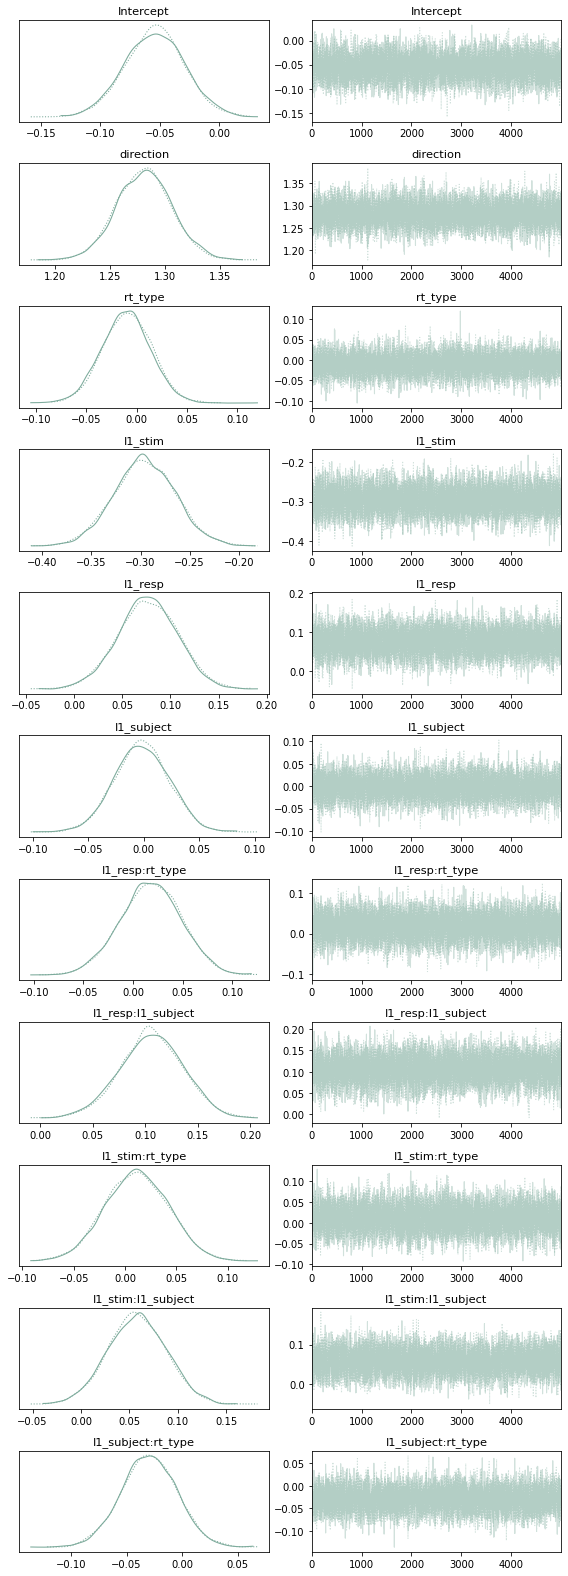

In [ ]:
fig,axes = plt.subplots(11,2,figsize=(8,22))
az.plot_trace(result2,compact=True,axes=axes)
plt.tight_layout()
plt.show()

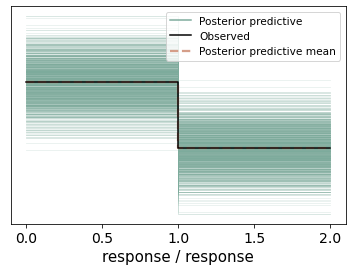

In [ ]:
post_pred2 = model2.predict(result2, kind="pps", draws=500)
az.plot_ppc(result2)

In [ ]:
az.summary(result2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.054,0.025,-0.102,-0.007,0.0,0.0,12977.0,7442.0,1.0
direction,1.281,0.025,1.233,1.328,0.0,0.0,12610.0,8480.0,1.0
rt_type,-0.010,0.024,-0.053,0.038,0.0,0.0,12269.0,8070.0,1.0
l1_stim,-0.296,0.031,-0.359,-0.240,0.0,0.0,9718.0,6824.0,1.0
l1_resp,0.076,0.031,0.017,0.133,0.0,0.0,10048.0,7979.0,1.0
l1_subject,-0.002,0.025,-0.046,0.046,0.0,0.0,13632.0,7737.0,1.0
l1_resp:rt_type,0.018,0.031,-0.039,0.076,0.0,0.0,10612.0,8290.0,1.0
l1_resp:l1_subject,0.106,0.030,0.051,0.164,0.0,0.0,10860.0,8219.0,1.0
l1_stim:rt_type,0.012,0.031,-0.047,0.069,0.0,0.0,10025.0,8245.0,1.0
l1_stim:l1_subject,0.058,0.030,0.002,0.114,0.0,0.0,10711.0,8333.0,1.0


**Fourth model:**

regressors are:


1.   Current trial: stimulus
2.   Prev trial: stimulus, response, correctness, rt , subject and their interactions


In [ ]:
model4 = bambi.Model("response['right'] ~ direction + l1_rt + l1_stim + l1_resp + l1_subject + l1_correct + l1_resp:l1_rt + l1_resp:l1_subject + l1_stim:l1_rt + l1_stim:l1_subject + l1_subject:l1_rt", model_data, family='bernoulli')

In [ ]:
result4 = model4.fit(draws=5000,chains=2)

Modeling the probability that response==right
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, l1_subject:l1_rt, l1_stim:l1_subject, l1_stim:l1_rt, l1_resp:l1_subject, l1_resp:l1_rt, l1_correct, l1_subject, l1_resp, l1_stim, l1_rt, direction]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 366 seconds.


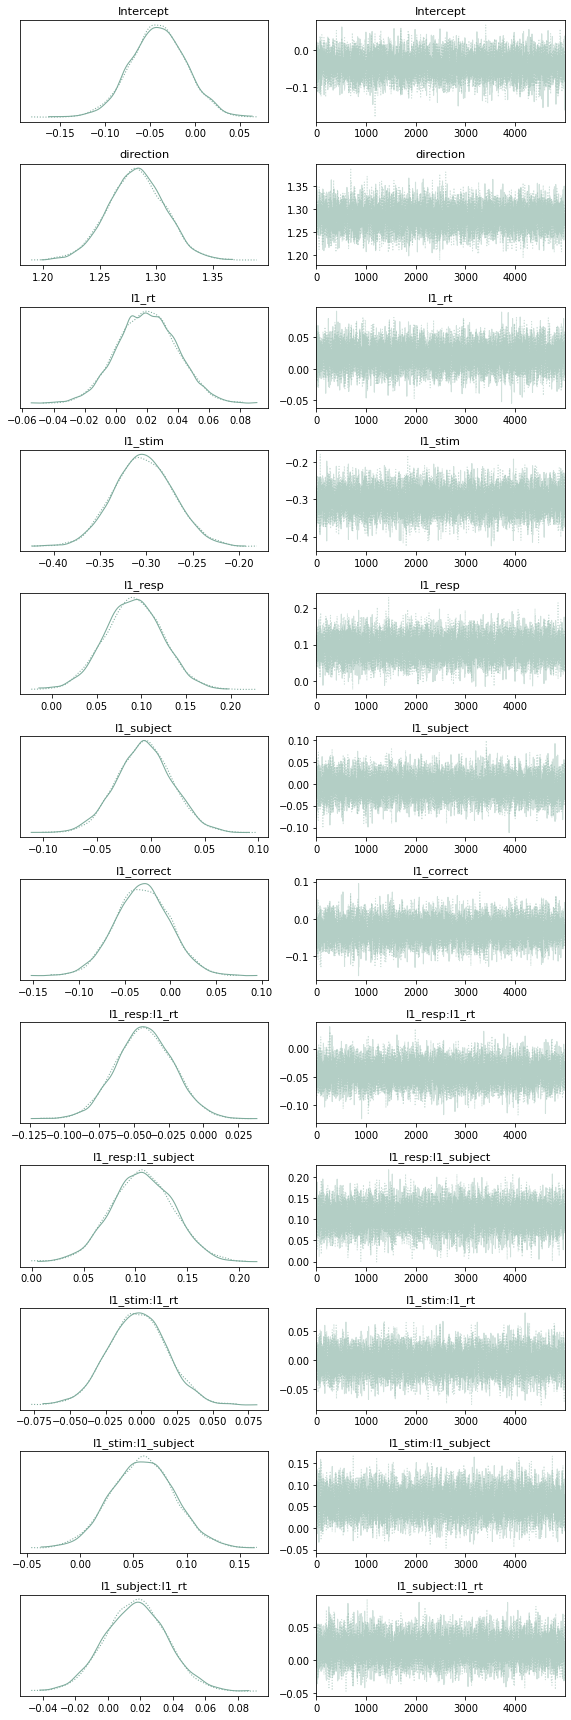

In [ ]:
fig,axes = plt.subplots(12,2,figsize=(8,24))
az.plot_trace(result4,compact=True,axes=axes)
plt.tight_layout()
plt.show()

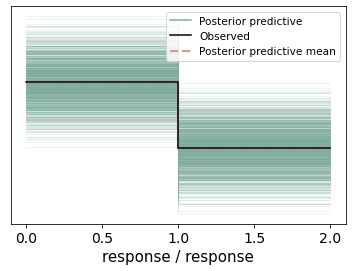

In [ ]:
post_pred4 = model4.predict(result4, kind="pps", draws=500)
az.plot_ppc(result4)

In [ ]:
az.summary(result4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.041,0.031,-0.098,0.019,0.0,0.0,14227.0,7592.0,1.0
direction,1.282,0.025,1.235,1.329,0.0,0.0,14110.0,8083.0,1.0
l1_rt,0.020,0.019,-0.014,0.056,0.0,0.0,15197.0,7741.0,1.0
l1_stim,-0.303,0.032,-0.362,-0.242,0.0,0.0,11049.0,8013.0,1.0
l1_resp,0.092,0.032,0.029,0.150,0.0,0.0,10346.0,7915.0,1.0
l1_subject,-0.006,0.026,-0.053,0.044,0.0,0.0,14479.0,7639.0,1.0
l1_correct,-0.031,0.030,-0.085,0.027,0.0,0.0,15550.0,8365.0,1.0
l1_resp:l1_rt,-0.042,0.020,-0.082,-0.005,0.0,0.0,10848.0,8102.0,1.0
l1_resp:l1_subject,0.107,0.030,0.052,0.164,0.0,0.0,13569.0,7907.0,1.0
l1_stim:l1_rt,-0.003,0.021,-0.040,0.036,0.0,0.0,11836.0,8624.0,1.0


**Third model:**

regressors are:


1.   Current trial: stimulus
2.   Prev trial: stimulus, response, rt , subject and their interactions + prev correct + prev correct and subject interaction

In [ ]:
model3 = bambi.Model("response['right'] ~ direction + l1_rt + l1_stim + l1_resp + l1_subject + l1_correct + l1_correct:l1_subject + l1_resp:l1_rt + l1_resp:l1_subject + l1_stim:l1_rt + l1_stim:l1_subject + l1_subject:l1_rt", model_data, family='bernoulli')

In [ ]:
result3 = model3.fit(draws=5000,chains=2)

Modeling the probability that response==right
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, l1_subject:l1_rt, l1_stim:l1_subject, l1_stim:l1_rt, l1_resp:l1_subject, l1_resp:l1_rt, l1_correct:l1_subject, l1_correct, l1_subject, l1_resp, l1_stim, l1_rt, direction]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 334 seconds.


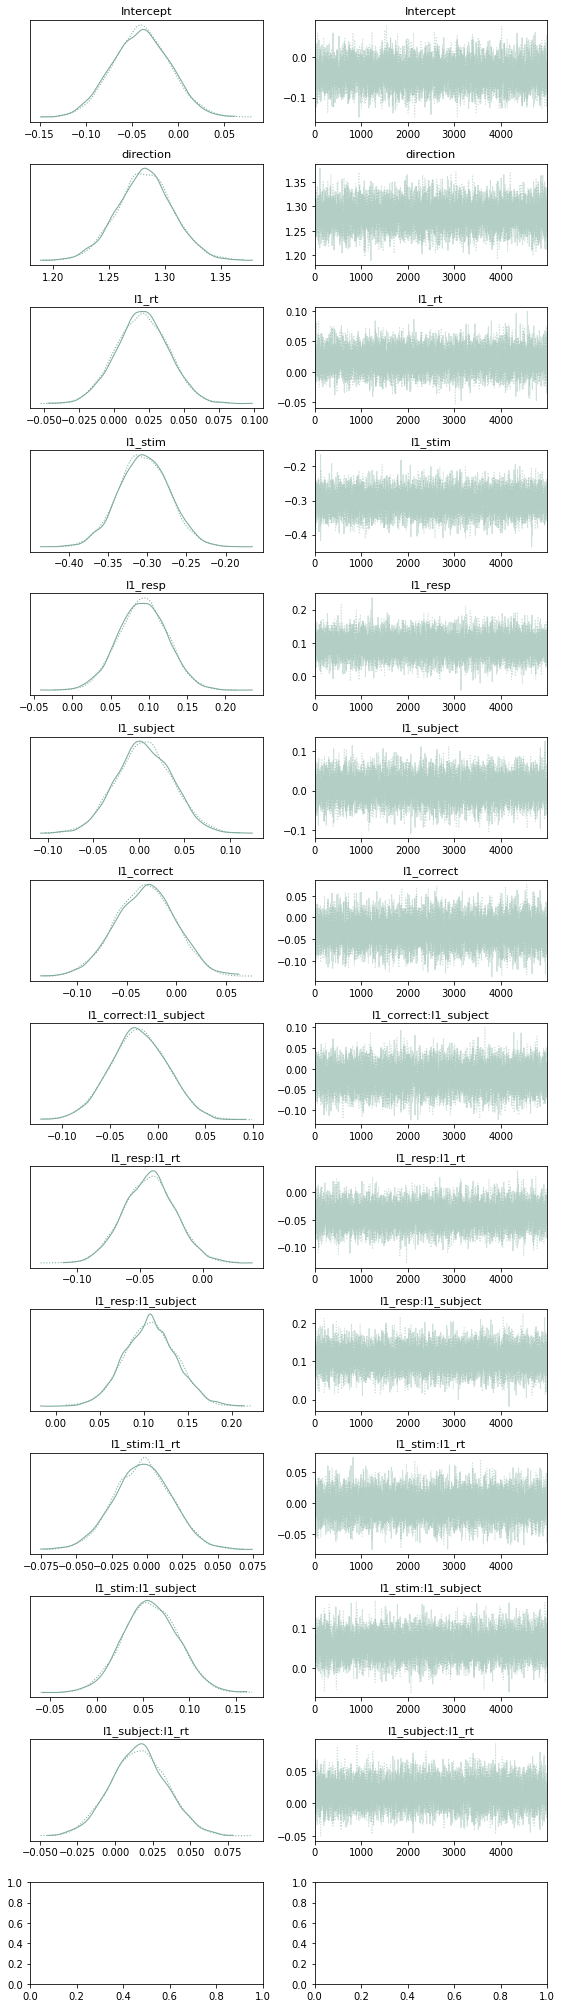

In [ ]:
fig,axes = plt.subplots(14,2,figsize=(8,28))
az.plot_trace(result3,compact=True,axes=axes)
plt.tight_layout()
plt.show()

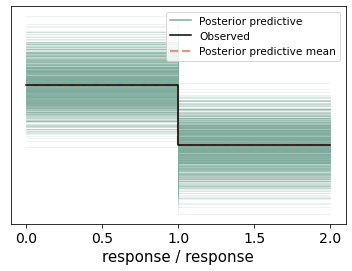

In [ ]:
post_pred3 = model3.predict(result3, kind="pps", draws=500)
az.plot_ppc(result3)

In [ ]:
az.summary(result3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.040,0.031,-0.095,0.022,0.0,0.0,13601.0,7649.0,1.0
direction,1.282,0.025,1.237,1.332,0.0,0.0,14073.0,7277.0,1.0
l1_rt,0.020,0.019,-0.014,0.055,0.0,0.0,13021.0,7045.0,1.0
l1_stim,-0.304,0.032,-0.366,-0.244,0.0,0.0,10346.0,7867.0,1.0
l1_resp,0.092,0.032,0.034,0.154,0.0,0.0,10644.0,7776.0,1.0
l1_subject,0.006,0.031,-0.052,0.063,0.0,0.0,11458.0,7282.0,1.0
l1_correct,-0.031,0.030,-0.089,0.024,0.0,0.0,13787.0,7660.0,1.0
l1_correct:l1_subject,-0.020,0.030,-0.075,0.037,0.0,0.0,11733.0,8172.0,1.0
l1_resp:l1_rt,-0.042,0.021,-0.079,-0.002,0.0,0.0,12082.0,8592.0,1.0
l1_resp:l1_subject,0.108,0.030,0.055,0.166,0.0,0.0,12151.0,8216.0,1.0


**Now compare the models**

In [ ]:
models_dict = {
    "model1": result1,
    "model2": result2,
    "model3": result3,
    "model4": result4
}
df_compare = az.compare(models_dict)
df_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model1,0,-4937.696361,11.455316,0.000000,9.119363e-01,51.472506,0.000000,False,log
model4,1,-4938.241776,12.529845,0.545415,5.551115e-17,51.489361,1.034092,False,log
model3,2,-4938.885494,13.403064,1.189133,0.000000e+00,51.499405,1.325739,False,log
model2,3,-4939.800096,11.064151,2.103736,8.806370e-02,51.468784,2.243852,False,log


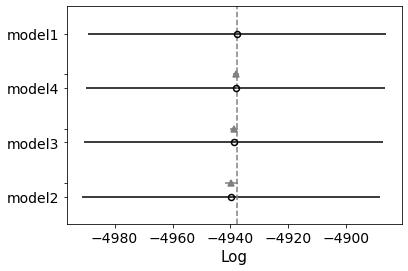

In [ ]:
az.plot_compare(df_compare, insample_dev=False)